<a href="https://colab.research.google.com/github/DreamWalker1412/Colab/blob/main/LDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU information

In [ ]:
!nvidia-smi

Thu Dec 24 09:08:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Resource preparation

## Import required libraries

Update pandas and pandas_profiling libraries before loading instance of pandas

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas_profiling

Call tersorflow 2.x version to support auto-keras and other related libraries

In [ ]:
%tensorflow_version 2.x
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.metrics import *

import scipy
from scipy import io as spio
from scipy import stats
import numpy as np
import pandas as pd

# Drawing tools
import matplotlib.pyplot as plt
import seaborn as sns

## Download datasets

Decompress the data stored in the Google disk to Colab, or you can download the data from Dropbox.


```
!wget -c https://www.dropbox.com/sh/oxk6087vnsazr60/AABgsh2rrC79aWDaXeC-4VXIa?dl=0 -O CADA_VAE.zip
!unzip CADA_VAE.zip
```



In [ ]:
!unzip /content/drive/'My Drive'/data/LDL/LDL_datasets_mat.zip
!unzip /content/drive/'My Drive'/data/MLL/MLL_datasets_mat.zip

Archive:  /content/drive/My Drive/data/LDL/LDL_datasets_mat.zip
   creating: data_mat/
  inflating: data_mat/Flickr.mat     
  inflating: data_mat/Human_Gene.mat  
  inflating: data_mat/JAFFE(Fear Excluded).mat  
  inflating: data_mat/JAFFE.mat      
  inflating: data_mat/Movie.mat      
  inflating: data_mat/Natural_Scene.mat  
  inflating: data_mat/SBU_3DFE.mat   
  inflating: data_mat/SJAFFE.mat     
  inflating: data_mat/Twitter.mat    
  inflating: data_mat/Yeast_alpha.mat  
  inflating: data_mat/Yeast_cdc.mat  
  inflating: data_mat/Yeast_cold.mat  
  inflating: data_mat/Yeast_diau.mat  
  inflating: data_mat/Yeast_dtt.mat  
  inflating: data_mat/Yeast_elu.mat  
  inflating: data_mat/Yeast_heat.mat  
  inflating: data_mat/Yeast_spo.mat  
  inflating: data_mat/Yeast_spo5.mat  
  inflating: data_mat/Yeast_spoem.mat  
Archive:  /content/drive/My Drive/data/MLL/MLL_datasets_mat.zip
   creating: ML_datasets/
  inflating: ML_datasets/Arts.mat    
  inflating: ML_datasets/business.mat  

Store the dataset path in a dictionary structure

In [ ]:
data_path = dict(
    # Label distribution learning datasets, beginning with an uppercase letter.
    Human_Gene='/content/data_mat/Human_Gene.mat',
    Movie='/content/data_mat/Movie.mat',
    Natural_Scene='/content/data_mat/Natural_Scene.mat',
    SBU_3DFE='/content/data_mat/SBU_3DFE.mat',
    SJAFFE='/content/data_mat/SJAFFE.mat',
    Yeast_alpha='/content/data_mat/Yeast_alpha.mat',
    Yeast_cdc='/content/data_mat/Yeast_cdc.mat',
    Yeast_cold='/content/data_mat/Yeast_cold.mat',
    Yeast_diau='/content/data_mat/Yeast_diau.mat',
    Yeast_dtt='/content/data_mat/Yeast_dtt.mat',
    Yeast_elu='/content/data_mat/Yeast_elu.mat',
    Yeast_heat='/content/data_mat/Yeast_heat.mat',
    Yeast_spo='/content/data_mat/Yeast_spo.mat',
    Yeast_spo5='/content/data_mat/Yeast_spo5.mat',
    Yeast_spoem='/content/data_mat/Yeast_spoem.mat',
    Flickr='/content/data_mat/Flickr.mat',
    Twitter='/content/data_mat/Twitter.mat',

    # Muti-label learning datasets, beginning with a lowercase letter.
    yahoo_arts='/content/ML_datasets/Arts.mat', 
    image='/content/ML_datasets/Image.mat',
    yahoo_business='/content/ML_datasets/business.mat',
    cal500='/content/ML_datasets/cal500.mat',
    enron='/content/ML_datasets/enron.mat',
    flags='/content/ML_datasets/flags.mat',
    genbase='/content/ML_datasets/genbase.mat',
    health='/content/ML_datasets/health.mat',
    llog='/content/ML_datasets/llog.mat',
    medical='/content/ML_datasets/medical.mat',
    slashdot='/content/ML_datasets/slashdot.mat',
    society='/content/ML_datasets/society.mat',
    yeast='/content/ML_datasets/yeast.mat'
    )

## Load data

Use "loadmat" function of scipy to read data in mat format. If it is csv format data, use pandas to read.

In [ ]:
dataset_name = 'SBU_3DFE'
data = spio.loadmat(data_path[dataset_name])
X = data['features']
y = data['labels']

In [ ]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 243) (500, 243) (2000, 6) (500, 6)


convent to single label and muli-label

In [ ]:
import numpy as np
import copy

# single label
def get_single_label(y):
  maxInRows = np.amax(y,axis=1)
  result = [np.where(y[i] == maxInRows[i],1,0) for i in range(len(y))]
  single_label = np.array(result)
  return single_label

# multi-label
def get_multi_label(y,set_threshold=0.3):
  ls = list() 
  index_sort = np.argsort(-y,axis=-1)
  for i in range(y.shape[0]):
    sum = 0
    y_sort_row = y[i][index_sort[i]]
    for j in range(y.shape[1]):
      sum += y_sort_row[j]
      if sum>=set_threshold:
        ls.append(y_sort_row[j])
        break
  result = [np.where(y[i] >= ls[i],1,0) for i in range(len(y))]
  multi_label = np.array(result)
  return multi_label

In [ ]:
y_sl_train = get_single_label(y_train)
y_sl_test = get_single_label(y_test)

y_ml_train = get_multi_label(y_train)
y_ml_test = get_multi_label(y_test)
print(y_sl_train.shape, y_sl_test.shape)
print(y_ml_train.shape, y_ml_test.shape)

(2000, 6) (500, 6)
(2000, 6) (500, 6)


Convert to DataFrame format data, check the statistical characteristics of features and labels.

In [ ]:
features = pd.DataFrame(X)
labels = pd.DataFrame(get_single_label(y))

labels.describe()

,0,1,2,3,4,5,6,7
count,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000
mean,0.102870,0.126099,0.594888,0.057937,0.020628,0.047803,0.068969,0.081525
std,0.303803,0.331975,0.490936,0.233635,0.142141,0.213358,0.253412,0.273651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Special for emotion datasets: "SJAFFE" & "SBU_3DFE"
if dataset_name in ['SJAFFE','SBU_3DFE']:
  labels = pd.DataFrame(y,columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear'])
elif dataset_name in ['Flickr','Twitter']:
  labels = pd.DataFrame(y,columns=['Amusement', 'Awe', 'Contentment', 'Excitement', 'Anger', 'Disgust','Fear','Sadness'])

labels.describe()

,Amusement,Awe,Contentment,Excitement,Anger,Disgust,Fear,Sadness
count,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000
mean,0.111570,0.115793,0.429735,0.091431,0.024688,0.063041,0.077350,0.086392
std,0.156394,0.187092,0.245724,0.138768,0.076649,0.127267,0.138386,0.166581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.090909,0.000000,0.454545,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.181818,0.181818,0.636364,0.090909,0.000000,0.090909,0.090909,0.090909
max,0.909091,0.909091,1.000000,0.909091,0.909091,1.000000,1.000000,1.000000


In [ ]:
labels_T = labels.transpose()
labels_T.std()
label_normalization =  (labels_T-labels_T.min())/(labels_T.max()-labels_T.min())
label_normalization.transpose().describe()

,Amusement,Awe,Contentment,Excitement,Anger,Disgust,Fear,Sadness
count,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000,11150.000000
mean,0.229528,0.219736,0.755411,0.177816,0.056368,0.125741,0.162405,0.167480
std,0.321093,0.344294,0.341291,0.268416,0.176366,0.244504,0.282105,0.297326
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.111111,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.333333,0.250000,1.000000,0.250000,0.000000,0.166667,0.200000,0.200000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
labels_T.std().describe()
labels_z = (labels_T-labels_T.mean())/labels_T.std()
labels_z.transpose().describe()

,Happy,Sad,Surprise,Anger,Disgust,Fear
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-0.022777,-0.024897,0.349866,0.021246,-0.235502,-0.087935
std,1.133335,0.793839,1.009938,0.664282,0.598188,1.039727
min,-1.932503,-1.488131,-1.651388,-1.459804,-1.936583,-1.852939
25%,-0.770892,-0.534903,-0.463033,-0.430860,-0.586595,-0.745163
50%,-0.560248,-0.408248,-0.193782,-0.242527,-0.408248,-0.529301
75%,0.550482,0.346046,1.447817,0.333323,-0.098439,0.000200
max,2.041241,2.036787,2.037014,2.026201,1.999115,2.041241


In [ ]:
# Special for emotion datasets: "SJAFFE" & "SBU_3DFE"
if dataset_name in ['SJAFFE','SBU_3DFE']:
  label_train = pd.DataFrame(y_train,columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear'])
else:
  label_train = pd.DataFrame(y_train)

label_train.describe()

,Happy,Sad,Surprise,Anger,Disgust,Fear
count,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000
mean,0.178437,0.156376,0.180185,0.159376,0.151039,0.174587
std,0.109652,0.056219,0.075269,0.044231,0.041548,0.096124
min,0.083333,0.085714,0.085714,0.085714,0.085714,0.090452
25%,0.111111,0.115699,0.118422,0.122179,0.125002,0.116883
50%,0.126866,0.137808,0.155708,0.154103,0.140422,0.132206
75%,0.181101,0.180440,0.223698,0.181822,0.161022,0.167802
max,0.488638,0.414014,0.416666,0.341931,0.391959,0.459456


In [ ]:
# Special for emotion datasets: "SJAFFE" & "SBU_3DFE"
if dataset_name in ['SJAFFE','SBU_3DFE']:
  label_test = pd.DataFrame(y_test,columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear'])
else:
  label_test = pd.DataFrame(y_test)
  
label_test.describe()

,Happy,Sad,Surprise,Anger,Disgust,Fear
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.180769,0.156049,0.180289,0.160913,0.148441,0.173539
std,0.107860,0.053896,0.073252,0.046159,0.036113,0.093595
min,0.078602,0.090000,0.090000,0.091837,0.093264,0.091892
25%,0.113334,0.117075,0.121023,0.124391,0.125000,0.117647
50%,0.130601,0.138071,0.160005,0.155050,0.141628,0.132231
75%,0.192511,0.179963,0.217211,0.181820,0.159420,0.162538
max,0.494050,0.422624,0.437498,0.325926,0.335050,0.442107


Distribution to logic label

In [ ]:
single_label = get_single_label(y)
multi_label = get_multi_label(y)

In [ ]:
def get_label_groups(X=X,y=y):
  logic_label = get_single_label(y)
  X_ls = [[]*j for j in range(logic_label.shape[1])]
  y_ls = [[]*j for j in range(logic_label.shape[1])]
  for i in range(logic_label.shape[0]):
    for j in range(logic_label.shape[1]):
      if logic_label[i][j] == 1:
        X_ls[j].append(X[i])
        y_ls[j].append(y[i])
  for j in range(y.shape[1]):
    X_ls[j]=np.asarray(X_ls[j])
    y_ls[j]=np.asarray(y_ls[j])
  return X_ls,y_ls

In [ ]:
(X_ls,y_ls) = get_label_groups(X_train,y_train)


In [ ]:
import copy

def cal_kurt_skew_entropy(labels):
  label_kurtosis = scipy.stats.kurtosis(labels, axis=1, fisher=False, bias=True)
  label_skewness = scipy.stats.skew(labels, axis=1, bias=True)
  label_entropy = scipy.stats.entropy(labels, axis=1)
  label_kurt_skew_entropy = np.c_[labels,label_kurtosis,label_skewness,label_entropy]
  return label_kurt_skew_entropy

def label_enhancement(label_groups):
  label_enhanced = copy.deepcopy(label_groups)
  num_label = label_groups[0].shape[1]
  ls = []
  for j in range(num_label):
    ls.append(y_ls[j].mean(axis=0))
  group_mean = np.asarray(ls) 
  mean_arr = np.asarray([group_mean[j,j] for j in range(num_label)])
  # dif = mean_arr - mean_arr.mean()
  dif = mean_arr - 0.6
  for j in range(num_label):
    labels = label_enhanced[j]
    labels += dif[j]/(num_label-1)
    labels[:,j] -= dif[j]/(num_label-1)+dif[j]
    label_enhanced[j] = labels
  return label_enhanced

In [ ]:
label_enhanced = label_enhancement(y_ls)
X_train_new = np.vstack( [X_ls[j] for j in range(y.shape[1])])
y_train_new = np.vstack( [label_enhanced[j] for j in range(y.shape[1])])

In [ ]:
# Special for emotion datasets: "SJAFFE" & "SBU_3DFE"
if dataset_name in ['SBU_3DFE','SJAFFE']:
  y_train_new_pd = pd.DataFrame(y_train_new,columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear'])
else:
  y_train_new_pd = pd.DataFrame(y_train_new)
y_train_new_pd.describe()


,Happy,Sad,Surprise,Anger,Disgust,Fear
count,1802.000000,1802.000000,1802.000000,1802.000000,1802.000000,1802.000000
mean,0.181885,0.155310,0.233079,0.142013,0.116660,0.171053
std,0.228080,0.183305,0.237202,0.152323,0.127316,0.212022
min,0.014155,0.020597,0.020597,0.022967,0.022284,0.025399
25%,0.048208,0.063130,0.067000,0.071811,0.065468,0.054701
50%,0.065469,0.080808,0.096594,0.092747,0.079914,0.071779
75%,0.117889,0.119894,0.537402,0.121795,0.105361,0.106519
max,0.728537,0.753334,0.739207,0.697998,0.729385,0.705289


# Data analysis


## Pandas_profiling


If you need further analysis, you can form an HTML report by pandas_profiling.

*Note that in the colab environment, the pandas and pandas_profiling libraries need to be updated before the pandas instance runs, and the data needs to be converted to the DataFrame type in pandas.*


In [ ]:
import pandas_profiling
# profile_feature = pandas_profiling.ProfileReport(features)
# profile_feature.to_file("feature report.html") 
profile_label = pandas_profiling.ProfileReport(labels)
profile_label.to_file("/content/drive/MyDrive/ProfileReport/label_report.html")

In [ ]:
def changeNumToChar(toSmallChar=None, toBigChar=None):
  init_number=0
  increment=0
  res_char = ''
  if toSmallChar!=None:
    init_number = toSmallChar
    increment = ord('a')
  else:
	  init_number = toBigChar
	  increment = ord('A')
  shang,yu = divmod(init_number, 26)
  char = chr(yu + increment)
  res_char = char * (shang + 1)
  return res_char

In [ ]:
analysis_dict = dict( 
    SBU_3DFE='/content/data_mat/SBU_3DFE.mat',
    SJAFFE='/content/data_mat/SJAFFE.mat',
    Flickr='/content/data_mat/Flickr.mat',
    Twitter='/content/data_mat/Twitter.mat',)

label_list_1 = ['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear', 'Kurtosis', 'Skewness', 'Entropy']
label_list_2 = ['Amusement', 'Awe', 'Contentment', 'Excitement', 'Anger', 'Disgust','Fear', 'Sadness', 'Kurtosis', 'Skewness', 'Entropy']

import pandas_profiling
for name in analysis_dict:
  data = spio.loadmat(data_path[name])
  X = data['features']
  y = data['labels']
  
  # features = pd.DataFrame(X)
  # profile_feature = pandas_profiling.ProfileReport(features)
  # profile_feature.to_file(name+"_feature_report.html")
  if name!='Human_Gene':
    labels = pd.DataFrame(y)
    label_kurtosis = scipy.stats.kurtosis(labels, axis=1, fisher=False, bias=True)
    label_skewness = scipy.stats.skew(labels, axis=1, bias=True)
    label_entropy = scipy.stats.entropy(labels, axis=1)
    label_kurt_skew_entropy = np.c_[y,label_kurtosis,label_skewness,label_entropy]
    if name in ['SBU_3DFE','SJAFFE']:
      label_kurt_skew_entropy = pd.DataFrame(label_kurt_skew_entropy,columns=label_list_1)
    elif name in ['Flickr','Twitter']:
      label_kurt_skew_entropy = pd.DataFrame(label_kurt_skew_entropy,columns=label_list_2)
    else:
      num_label = label_kurt_skew_entropy.shape[1]
      label_kurt_skew_entropy = pd.DataFrame(label_kurt_skew_entropy,columns=["label("+changeNumToChar(i)+')' for i in range(num_label)])
      label_kurt_skew_entropy.rename(columns={'label('+changeNumToChar(num_label-3)+')':'kurtosis',
                          'label('+changeNumToChar(num_label-2)+')':'skewness',
                          'label('+changeNumToChar(num_label-1)+')':'entropy'},inplace=True)
    profile_label = pandas_profiling.ProfileReport(label_kurt_skew_entropy)
    profile_label.to_file("/content/drive/MyDrive/ProfileReport/LDL/"+name+"_label_report.html")



## Kurtosis and skewness analysis

Calculate Kurtosis of Every Annotated Label

In [ ]:
label_kurtosis = scipy.stats.kurtosis(labels, axis=1, fisher=False, bias=True)
label_kurtosis = np.c_[y,label_kurtosis]
label_kurtosis = pd.DataFrame(label_kurtosis)
kurtosis_sort = label_kurtosis.sort_values(labels.shape[1]-1,axis=0)

# kurtosis_sort.columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear','Kurtosis']
kurtosis_sort.describe()

In [ ]:
kurtosis_sort[-30:]

In [ ]:
label_skewness = scipy.stats.skew(labels, axis=1, bias=True)
label_skewness = np.c_[y,label_skewness]
label_skewness = pd.DataFrame(label_skewness)
skewness_sort = label_skewness.sort_values(labels.shape[1]-1,axis=0)

# skewness_sort.columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear','Skewness']
skewness_sort.describe()

In [ ]:
label_entropy = scipy.stats.entropy(labels, axis=1)
label_entropy = np.c_[y,label_entropy]
label_entropy = pd.DataFrame(label_entropy)
entropy_sort = label_entropy.sort_values(labels.shape[1]-1,axis=0)

# entropy_sort.columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear','Entropy']
entropy_sort.describe()

## Preprocess features

Not all algorithms need to pre-process the features in advance. If confirmed, you can normalize or reduce the dimensions of the features.

In [ ]:
scalerstd = preprocessing.StandardScaler().fit(X)
X = scalerstd.transform(X)

In [ ]:
scalermm = preprocessing.MinMaxScaler().fit(X)
X = scalermm.transform(X)

Check feature statistics after preprocessing.

In [ ]:
features_processed = pd.DataFrame(X)
features_processed.describe()


# Define metrics

## Multi-label learning

Define multi-label problem metrics


> Since some instances of missing labels may appear in the test set during random division, it is more appropriate to use the micro method to evaluate the classification model.




In [ ]:
from sklearn.metrics import *

def clf_eval(y_test, y_pred, y_scores):
  acc = accuracy_score(y_test,y_pred)
  print("acc:",acc)

  f1_micro = f1_score(y_test, y_pred,average="micro") 
  print("f1 score(micro):",f1_micro)

  precision_micro = precision_score(y_test, y_pred,average="micro") 
  print("precision score(micro):",precision_micro)

  recall_micro = recall_score(y_test, y_pred,average="micro") 
  print("recall score(micro):",recall_micro)

  AUC_micro = roc_auc_score(y_test, y_pred, average='micro')
  print("AUC score(micro):",AUC_micro)

  loss_hamming = hamming_loss(y_test, y_pred)  
  print("hamming loss:",loss_hamming)

  loss_ranking = label_ranking_loss(y_test, y_scores)
  print("label ranking loss:",loss_ranking)
  
  confusion_matrix = multilabel_confusion_matrix(y_test, y_pred)
  print("confusion matrix:",confusion_matrix)
  return acc, f1_micro, precision_micro, recall_micro, loss_hamming, loss_ranking, confusion_matrix
  
  #l = label_ranking_average_precision_score(y_test, y_pred)
  #print("label ranking average precision score：",l)

  #c = coverage_error(y_test, y_scores)
  #print("coverage error:",c)



## Label distribution learning

Define LDL metrics

In [ ]:
from sklearn.metrics import *
import scipy
from scipy.spatial import distance
import numpy as np

def ldl_eval(y_test, y_pred):
  eps = np.finfo(np.float64).eps
  for i in range(len(y_test)):
    y_test[i] = y_test[i]/np.sum(y_test[i])
    y_pred[i] = y_pred[i]/np.sum(y_pred[i])
  
  # distance
  kl = np.mean(scipy.stats.entropy(y_test+eps,y_pred+eps,axis=1))
  print("Kullback–Leibler divergence: ",kl)

  euclidean_distance = np.mean(np.linalg.norm(y_test-y_pred,axis=1))
  print("Euclidean distance: ",euclidean_distance)

  mse = np.mean(np.power(y_test-y_pred,2))
  print("MSE: ",mse)

  chebyshev = np.mean(np.max(np.abs(y_test-y_pred),axis=1))
  print("Chebyshev distance: ",chebyshev)

  clark = np.mean(np.sqrt(np.sum(np.power(y_test-y_pred,2)/np.power(y_test+y_pred,2),axis=1)))
  print("Clark distance: ",clark)

  canberra = np.mean(np.sum(np.abs(y_test-y_pred)/(y_test+y_pred),axis=1))
  print("Canberra distance: ",canberra)

  # similarity
  cosine = np.mean( [1.0-scipy.spatial.distance.cosine(y_test[i],y_pred[i]) for i in range(len(y_test))])
  print("Cosine similarity: ",cosine)

  intersection = np.mean(np.sum(np.min([y_test,y_pred],axis=0),axis=1))
  print("Intersection similarity: ",intersection)

  # ambiguity 
  kurtosis_pred = scipy.stats.kurtosis(y_pred, axis=1, fisher=False, bias=True)
  kurtosis_test = scipy.stats.kurtosis(y_test, axis=1, fisher=False, bias=True)
  kurtosis_dif = kurtosis_pred - kurtosis_test
  kurtosis_signed_offset = np.mean(kurtosis_dif)
  kurtosis_abs_offset = np.mean(np.abs(kurtosis_dif))
  laloss = np.mean([ -x if x < 0 else 0 for x in kurtosis_dif])
  print("Kurtosis_signed_offset: ",kurtosis_signed_offset)
  print("Kurtosis_abs_offset: ",kurtosis_abs_offset)
  print("Laloss: ",laloss)



  return kl, euclidean_distance, mse, chebyshev,
  clark, canberra, cosine, intersection,
  kurtosis_signed_offset, kurtosis_abs_offset, laloss

# Sklearn

## Classification model (special for multi-label problems)

Define multi-label specific prediction function to get the prediction labels and scores.

In [ ]:
def clf_pre(clf, X_test):
  y_pred = clf.predict(X_test)
  y_proba = clf.predict_proba(X_test)
  y_scores = np.zeros(y_pred.shape)
  y_scores_t = y_scores.T
  for i in range(len(y_scores_t)):
    for j in range(len(y_scores_t[0])):
      y_scores_t[i][j] = 1 - y_proba[i][j,0]
  y_scores = y_scores_t.T
  return y_pred, y_scores


### KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf_KNN = KNeighborsClassifier()
clf_KNN.fit(X_train, y_ml_train)
y_pred, y_scores = clf_pre(clf_KNN,X_test)
print('KNN Eval')
eval_KNN = clf_eval(y_ml_test,y_pred,y_scores)
eval_KNN2 = ldl_eval(y_test,y_scores)

### Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RandomForest = RandomForestClassifier(n_estimators=100)
clf_RandomForest.fit(X_train, y_ml_train)
y_pred, y_scores = clf_pre(clf_RandomForest,X_test)
print('RandomForest Eval')
eval_RF = clf_eval(y_ml_test,y_pred,y_scores)
eval_RF2 = ldl_eval(y_test,y_scores)

On training set

In [ ]:
y_pred, y_scores = clf_pre(clf_RandomForest,X_train)
print('RandomForest Eval')
print('On training Set')
eval_RF = clf_eval(y_ml_train,y_pred,y_scores)

### Feature engineering attempt

Get the top ten features with the largest information gain.

In [ ]:
importances = clf_RandomForest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Importance of the top 10 features")
for f in range(min(20,X_train.shape[1])):
    print ("%2d) %-*s %f" % (f+1,30,indices[f],importances[indices[f]]) )

Try: combine the top 10 features

In [ ]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()
for i in range(min(10,X_train.shape[1])):
  for j in range(min(10,X_train.shape[1])):
    if i>=j:
      features_combined_train = X_train[:,indices[i]] * X_train[:,indices[j]]
      X_train_processed = np.column_stack((X_train,features_combined_train.T))
      features_combined_test = X_test[:,indices[i]] * X_test[:,indices[j]]
      X_test_processed = np.column_stack((X_test,features_combined_test.T))

print(X_train_processed.shape)
print(X_test_processed.shape)

Evaluated by RF classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RandomForest = RandomForestClassifier(n_estimators=100)
clf_RandomForest.fit(X_train_processed, y_train)
y_pred, y_scores = clf_pre(clf_RandomForest,X_test_processed)
print('RandomForest Eval')
eval_RF = clf_eval(y_test,y_pred,y_scores)

## Regression model (special for label distribution problems)

### SVR

In [ ]:
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
regressor_svr = MultiOutputRegressor(svm.SVR())
regressor_svr.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.1, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False),
                     n_jobs=None)

In [ ]:
y_pred = regressor_svr.predict(X_test)
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i]/np.sum(y_pred[i])

print("Testing set")

sl_eval = clf_eval(get_single_label(y_test),get_single_label(y_pred),y_pred)
ml_eval = clf_eval(get_multi_label(y_test),get_multi_label(y_pred),y_pred)
loss_test_mean = ldl_eval(y_test,y_pred)

Testing set
acc: 0.37333333333333335
f1 score(micro): 0.37319316688567666
precision score(micro): 0.37866666666666665
recall score(micro): 0.36787564766839376
AUC score(micro): 0.6214378238341969
hamming loss: 0.212
label ranking loss: 0.3287888888888889
confusion matrix: [[[501  76]
  [112  61]]

 [[650   0]
  [100   0]]

 [[327 193]
  [106 124]]

 [[662   0]
  [ 88   0]]

 [[713   0]
  [ 37   0]]

 [[409 197]
  [ 45  99]]]
acc: 0.04533333333333334
f1 score(micro): 0.425359380759307
precision score(micro): 0.38466666666666666
recall score(micro): 0.4756801319043693
AUC score(micro): 0.5974384839625284
hamming loss: 0.34644444444444444
label ranking loss: 0.3589259259259259
confusion matrix: [[[221 317]
  [ 44 168]]

 [[507  33]
  [182  28]]

 [[145 285]
  [ 59 261]]

 [[534   0]
  [216   0]]

 [[606  58]
  [ 84   2]]

 [[351 230]
  [ 51 118]]]
Kullback–Leibler divergence:  0.0763776037678445
Euclidean distance:  0.15873612697394243
MSE:  0.005132965883368118
Chebyshev distance:  0.130

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Evaluate the kl loss on the training set.

In [ ]:
y_pred_train = regressor.predict(X_train)

for i in range(len(y_pred_train)):
  y_pred_train[i] = y_pred_train[i]/sum(y_pred_train[i])
  
print("Training set")
loss_train_mean = ldl_eval(y_train,y_pred_train)

Training set
Kullback–Leibler divergence:  0.14403391478037555
Euclidean distance:  0.14535064036678005
MSE:  0.0031256182596449654
Chebyshev distance:  0.11341969017529563
Clark distance:  nan
Canberra distance:  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Cosine similarity:  0.9780090306270477
Intersection similarity:  0.8488760701182225
Kurtosis_signed_offset:  -0.015575000196273248
Kurtosis_abs_offset:  0.6084820865960565
Laloss:  0.312028543396165


Evaluate the kl loss on the testing set

In [ ]:
y_pred = regressor.predict(X_test)
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i]/np.sum(y_pred[i])

print("Testing set")

sl_eval = clf_eval(get_single_label(y_test),get_single_label(y_pred),y_pred)
ml_eval = clf_eval(get_multi_label(y_test),get_multi_label(y_pred),y_pred)
loss_test_mean = ldl_eval(y_test,y_pred)

Testing set
acc: 0.48933333333333334
f1 score(micro): 0.49408672798948744
precision score(micro): 0.5013333333333333
recall score(micro): 0.48704663212435234
AUC score(micro): 0.6933623718561676
hamming loss: 0.1711111111111111
label ranking loss: 0.23394814814814816
confusion matrix: [[[472 105]
  [ 64 109]]

 [[640  10]
  [ 90  10]]

 [[329 191]
  [ 68 162]]

 [[659   3]
  [ 85   3]]

 [[710   3]
  [ 37   0]]

 [[544  62]
  [ 52  92]]]
acc: 0.156
f1 score(micro): 0.5132275132275133
precision score(micro): 0.473831123517097
recall score(micro): 0.5597691673536686
AUC score(micro): 0.665190333600777
hamming loss: 0.2862222222222222
label ranking loss: 0.24960370370370372
confusion matrix: [[[342 196]
  [ 56 156]]

 [[483  57]
  [138  72]]

 [[161 269]
  [ 36 284]]

 [[442  92]
  [161  55]]

 [[635  29]
  [ 83   3]]

 [[470 111]
  [ 60 109]]]
Kullback–Leibler divergence:  0.055973061029926004
Euclidean distance:  0.13400012910974346
MSE:  0.0037962159548448468
Chebyshev distance:  0.107

In [ ]:
y_pred = regressor2.predict(X_test)
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i]/np.sum(y_pred[i])

print("Testing set")

sl_eval = clf_eval(get_single_label(y_test),get_single_label(y_pred),y_pred)
ml_eval = clf_eval(get_multi_label(y_test),get_multi_label(y_pred),y_pred)
loss_test_mean = ldl_eval(y_test,y_pred)

Testing set
acc: 0.48533333333333334
f1 score(micro): 0.4907407407407407
precision score(micro): 0.49466666666666664
recall score(micro): 0.4868766404199475
AUC score(micro): 0.6927427610874483
hamming loss: 0.1711111111111111
label ranking loss: 0.23013333333333333
confusion matrix: [[[512  69]
  [ 73  96]]

 [[622  22]
  [ 91  15]]

 [[298 241]
  [ 40 171]]

 [[652  18]
  [ 70  10]]

 [[702   3]
  [ 44   1]]

 [[573  26]
  [ 73  78]]]
acc: 0.204
f1 score(micro): 0.5363601385148133
precision score(micro): 0.49750178443968596
recall score(micro): 0.5818030050083473
AUC score(micro): 0.6842994431462088
hamming loss: 0.2677777777777778
label ranking loss: 0.23342962962962963
confusion matrix: [[[433 117]
  [ 73 127]]

 [[408 139]
  [ 97 106]]

 [[165 272]
  [ 24 289]]

 [[446  99]
  [141  64]]

 [[633  18]
  [ 87  12]]

 [[513  59]
  [ 79  99]]]
Kullback–Leibler divergence:  0.05999203885618337
Euclidean distance:  0.1386967649513472
MSE:  0.004099387457888263
Chebyshev distance:  0.1093

Calculate Kurtosis of Annotated Labels on Test Set

In [ ]:
label_kurtosis = scipy.stats.kurtosis(y_test, axis=1, fisher=False, bias=True)
label_kurtosis = np.c_[y_test,label_kurtosis]
label_kurtosis = pd.DataFrame(label_kurtosis)
kurtosis_sort = label_kurtosis.sort_values(labels.shape[1]-1,axis=0)

# kurtosis_sort.columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear','Kurtosis']
kurtosis_sort.describe()

,0,1,2,3,4,5,6
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.164181,0.173232,0.163764,0.164016,0.181437,0.153370,2.767488
std,0.112310,0.052366,0.075027,0.056674,0.057771,0.028992,0.882297
min,0.067433,0.099451,0.086907,0.096532,0.100281,0.099458,1.357919
25%,0.086074,0.133765,0.114018,0.122685,0.127356,0.131960,2.050240
50%,0.113784,0.162520,0.130567,0.141802,0.173124,0.152279,2.662803
75%,0.184334,0.192755,0.179354,0.197822,0.235069,0.171473,3.425403
max,0.456420,0.330827,0.358845,0.317175,0.306174,0.233681,4.188581


Calculate Kurtosis of Predicted Labels on Test Set （need y_pred）

In [ ]:
label_kurtosis = scipy.stats.kurtosis(y_pred, axis=1, fisher=False, bias=True)
label_kurtosis = np.c_[y_pred,label_kurtosis]
label_kurtosis = pd.DataFrame(label_kurtosis)
kurtosis_sort = label_kurtosis.sort_values(labels.shape[1]-1,axis=0)

# kurtosis_sort.columns=['Happy', 'Sad', 'Surprise', 'Anger', 'Disgust', 'Fear','Kurtosis']
kurtosis_sort.describe()

,0,1,2,3,4,5,6
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.155469,0.175041,0.166498,0.164355,0.182326,0.156312,2.199864
std,0.035653,0.011751,0.027917,0.016113,0.019079,0.007720,0.823385
min,0.107750,0.143283,0.124946,0.123986,0.129556,0.129489,1.260523
25%,0.135349,0.166956,0.146199,0.152428,0.171541,0.152960,1.618657
50%,0.145497,0.177620,0.158399,0.163267,0.182870,0.156812,1.906927
75%,0.162892,0.182972,0.182037,0.176285,0.197734,0.161615,2.655288
max,0.303983,0.192161,0.257398,0.211255,0.221861,0.170987,3.994224


# keras

In [ ]:
# Using TensorFlow as keras backend
import tensorflow as tf

from tensorflow import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Input
from keras.utils import get_file,to_categorical
from keras import regularizers

from keras import backend as K

## Define Loss functions

Define LDL loss functions

In [ ]:
def kurt_cal(y):
  mean = tf.reduce_mean(y,axis=-1,keepdims=True)
  std = tf.keras.backend.std(y,axis=-1,keepdims=True)
  kurt = tf.reduce_mean(tf.pow((y-mean)/std,4),axis=-1)
  return kurt

def new_kurt_cal(y):
  mean = tf.reduce_mean(y,axis=-1,keepdims=True)
  std = tf.keras.backend.std(y,axis=-1,keepdims=True)
  dif = y-mean
  dif_above_zero = tf.reduce_max([dif,tf.zeros_like(dif)],axis=0)
  new_kurt = tf.reduce_mean(tf.pow((dif_above_zero)/std,4),axis=-1)
  return new_kurt
  
def label_ambiguity_loss(y_true, y_pred):
  kurt_dif = kurt_cal(y_true)-kurt_cal(y_pred)
  # la_loss = tf.reduce_max([kurt_dif,tf.zeros_like(kurt_dif)])
  laloss_abs = tf.abs(kurt_cal(y_true)-kurt_cal(y_pred))
  # mse = tf.reduce_mean(tf.pow((y_true-y_pred),2))
  kl = tf.keras.losses.KLDivergence()
  kl_loss = kl(y_true, y_pred)
  loss = kl_loss * laloss_abs
  return loss

def new_label_ambiguity_loss(y_true, y_pred):
  kurt_dif = new_kurt_cal(y_true)-new_kurt_cal(y_pred)
  la_loss = tf.reduce_max([kurt_dif,tf.zeros_like(kurt_dif)])
  # laloss_abs = tf.abs(kurt_cal(y_true)-kurt_cal(y_pred))
  # mse = tf.reduce_mean(tf.pow((y_true-y_pred),2))
  kl = tf.keras.losses.KLDivergence()
  kl_loss = kl(y_true, y_pred)
  loss = kl_loss + 0.001 * la_loss
  return loss

def weighted_kl(y_true, y_pred):
  kl = tf.keras.losses.KLDivergence()
  weight = kurt_cal(y_true)
  weighted_kl = kl(y_true, y_pred, sample_weight= tf.reduce_min([weight,tf.ones_like(weight)*3],axis=0))
  return weighted_kl

In [ ]:
"""
y = tf.constant([[0.1,0.3,0.4,0.2],[0.2,0.6,0.1,0.3]])
mean = tf.reduce_mean(y,axis=-1,keepdims=True)
std = tf.keras.backend.std(y,axis=-1,keepdims=True)
kurt = tf.reduce_mean(tf.pow((y-mean)/std,4),axis=-1)
kurt.numpy()
kurtosis_scipy = scipy.stats.kurtosis(y.numpy(), axis=1, fisher=False, bias=True)
kurtosis_scipy-kurt.numpy()

y_true = y
y_pred = y/std
kurt_dif = kurt_cal(y_true)-kurt_cal(y_pred)
laloss = tf.reduce_max([-kurt_dif,tf.zeros(kurt_dif.shape)],axis=0)
kl = tf.keras.losses.KLDivergence()
weight = kurt_cal(y_true)
tf.ones_like(weight)*3
weighted_kl = kl(y_true, y_pred, sample_weight= tf.reduce_min([weight,tf.ones_like(weight)*3],axis=0))
mean = tf.reduce_mean(y,axis=-1,keepdims=True)
std = tf.keras.backend.std(y,axis=-1,keepdims=True)
dif = y-mean
dif_above_zero = tf.reduce_max([dif,tf.zeros_like(dif)],axis=0)
new_kurt = tf.reduce_mean(tf.pow((dif_above_zero)/std,4),axis=-1)
new_kurt
"""

'\ny = tf.constant([[0.1,0.3,0.4,0.2],[0.2,0.6,0.1,0.3]])\nmean = tf.reduce_mean(y,axis=-1,keepdims=True)\nstd = tf.keras.backend.std(y,axis=-1,keepdims=True)\nkurt = tf.reduce_mean(tf.pow((y-mean)/std,4),axis=-1)\nkurt.numpy()\nkurtosis_scipy = scipy.stats.kurtosis(y.numpy(), axis=1, fisher=False, bias=True)\nkurtosis_scipy-kurt.numpy()\n\ny_true = y\ny_pred = y/std\nkurt_dif = kurt_cal(y_true)-kurt_cal(y_pred)\nlaloss = tf.reduce_max([-kurt_dif,tf.zeros(kurt_dif.shape)],axis=0)\nkl = tf.keras.losses.KLDivergence()\nweight = kurt_cal(y_true)\ntf.ones_like(weight)*3\nweighted_kl = kl(y_true, y_pred, sample_weight= tf.reduce_min([weight,tf.ones_like(weight)*3],axis=0))\nmean = tf.reduce_mean(y,axis=-1,keepdims=True)\nstd = tf.keras.backend.std(y,axis=-1,keepdims=True)\ndif = y-mean\ndif_above_zero = tf.reduce_max([dif,tf.zeros_like(dif)],axis=0)\nnew_kurt = tf.reduce_mean(tf.pow((dif_above_zero)/std,4),axis=-1)\nnew_kurt\n'

## Define Metrics

In [ ]:
def laloss(y_true, y_pred):
  kurt_dif = kurt_cal(y_true)-kurt_cal(y_pred)
  laloss = tf.reduce_max([kurt_dif,tf.zeros_like(kurt_dif)])
  return laloss

def new_laloss(y_true, y_pred):
  kurt_dif = new_kurt_cal(y_true)-new_kurt_cal(y_pred)
  laloss = tf.reduce_max([kurt_dif,tf.zeros_like(kurt_dif)])
  return laloss

## LDL net

In [ ]:
feature_dim = X.shape[1]
label_dim = y.shape[1]

def get_model():
  model = Sequential()
  model.add(Dense(64,activation='relu',input_shape=(feature_dim,)))
  model.add(Dropout(0.4))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(label_dim, activation='softmax'))
  return model

def get_model_baseline():
  model = Sequential()
  model.add(Dense(64,activation='relu',input_shape=(feature_dim,)))
  model.add(Dropout(0.4))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(label_dim, activation='softmax'))
  model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss= 'kullback_leibler_divergence', metrics=['kullback_leibler_divergence',laloss,new_laloss,weighted_kl])
  return model

### Validate

In [ ]:
val_num = np.int32(len(X_train)/10)
X_val = X_train[:val_num]
partial_X_train = X_train[val_num:]
y_val = y_train[:val_num]
partial_y_train = y_train[val_num:]
val_num

200

In [ ]:
model = get_model()
model.compile(optimizer=keras.optimizers.RMSprop(),loss= label_ambiguity_loss, metrics=['acc','kullback_leibler_divergence',laloss])
history = model.fit(partial_X_train,partial_y_train,batch_size=256,epochs=200,validation_data=(X_val,y_val),verbose=1)

In [ ]:
model_baseline = get_model()
model_baseline.compile(optimizer=keras.optimizers.RMSprop(),loss= 'kullback_leibler_divergence', metrics=['acc','kullback_leibler_divergence',laloss])
history_baseline = model_baseline.fit(partial_X_train,partial_y_train,batch_size=256,epochs=200,validation_data=(X_val,y_val),verbose=1)

Epoch 1/200
8/8 [==============================] - 1s 31ms/step - loss: 0.0841 - acc: 0.2023 - kullback_leibler_divergence: 0.0841 - laloss: 2.8734 - val_loss: 0.0841 - val_acc: 0.2750 - val_kullback_leibler_divergence: 0.0841 - val_laloss: 2.2106
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0838 - acc: 0.2990 - kullback_leibler_divergence: 0.0838 - laloss: 2.8964 - val_loss: 0.0836 - val_acc: 0.2750 - val_kullback_leibler_divergence: 0.0836 - val_laloss: 2.5828
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0836 - acc: 0.2854 - kullback_leibler_divergence: 0.0836 - laloss: 2.9430 - val_loss: 0.0834 - val_acc: 0.2750 - val_kullback_leibler_divergence: 0.0834 - val_laloss: 2.3658
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0814 - acc: 0.2639 - kullback_leibler_divergence: 0.0814 - laloss: 2.8974 - val_loss: 0.0834 - val_acc: 0.2300 - val_kullback_leibler_divergence: 0.0834 - val_laloss: 2.7850
Epoch 5/200

In [ ]:
y_pred_baseline = model_baseline.predict(X_test)

eval_baseline_sll = clf_eval(y_sl_test,get_single_label(y_pred_baseline),y_pred)
eval_baseline_mll = clf_eval(y_ml_test,get_multi_label(y_pred_baseline),y_pred)
eval_baseline = ldl_eval(y_test,y_pred_baseline)

acc: 0.336
f1 score(micro): 0.3444881889763779
precision score(micro): 0.35
recall score(micro): 0.3391472868217054
AUC score(micro): 0.6041549638617383
hamming loss: 0.222
label ranking loss: 0.32535000000000003
confusion matrix: [[[373  11]
  [101  15]]

 [[418   0]
  [ 82   0]]

 [[187 162]
  [ 57  94]]

 [[447   0]
  [ 53   0]]

 [[475   0]
  [ 25   0]]

 [[259 152]
  [ 23  66]]]
acc: 0.1
f1 score(micro): 0.4031981724728726
precision score(micro): 0.37236286919831224
recall score(micro): 0.4396014943960149
AUC score(micro): 0.5843888218452538
hamming loss: 0.34833333333333333
label ranking loss: 0.32190555555555556
confusion matrix: [[[187 177]
  [ 37  99]]

 [[326  12]
  [154   8]]

 [[106 184]
  [ 45 165]]

 [[370   0]
  [130   0]]

 [[395  48]
  [ 51   6]]

 [[218 174]
  [ 33  75]]]
Kullback–Leibler divergence:  0.07822978994203554
Euclidean distance:  0.15877945818945868
MSE:  0.005309593031847453
Chebyshev distance:  0.1281805452083467
Clark distance:  0.3932137098298129
Canbe

In [ ]:
model = model_baseline
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),loss= label_ambiguity_loss, metrics=['acc','kullback_leibler_divergence',laloss])
history = model.fit(partial_X_train,partial_y_train,batch_size=256,epochs=100,validation_data=(X_val,y_val),verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 37ms/step - loss: 0.0806 - acc: 0.3556 - kullback_leibler_divergence: 0.0762 - laloss: 2.8134 - val_loss: 0.0823 - val_acc: 0.2850 - val_kullback_leibler_divergence: 0.0806 - val_laloss: 2.8006
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0785 - acc: 0.3551 - kullback_leibler_divergence: 0.0774 - laloss: 2.6844 - val_loss: 0.0778 - val_acc: 0.3100 - val_kullback_leibler_divergence: 0.0794 - val_laloss: 2.8353
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0730 - acc: 0.3580 - kullback_leibler_divergence: 0.0745 - laloss: 2.6465 - val_loss: 0.0763 - val_acc: 0.3150 - val_kullback_leibler_divergence: 0.0793 - val_laloss: 2.7404
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0734 - acc: 0.3529 - kullback_leibler_divergence: 0.0752 - laloss: 2.7153 - val_loss: 0.0747 - val_acc: 0.3050 - val_kullback_leibler_divergence: 0.0793 - val_laloss: 2.6485
Epoch 5/100

In [ ]:
y_pred = model.predict(X_test)

eval_sll = clf_eval(y_sl_test,get_single_label(y_pred),y_pred)
eval_mll = clf_eval(y_ml_test,get_multi_label(y_pred),y_pred)
eval = ldl_eval(y_test,y_pred)

acc: 0.336
f1 score(micro): 0.35236220472440943
precision score(micro): 0.358
recall score(micro): 0.34689922480620156
AUC score(micro): 0.6088360858330525
hamming loss: 0.21933333333333332
label ranking loss: 0.33914999999999995
confusion matrix: [[[384   0]
  [116   0]]

 [[418   0]
  [ 82   0]]

 [[100 249]
  [ 24 127]]

 [[447   0]
  [ 53   0]]

 [[475   0]
  [ 25   0]]

 [[339  72]
  [ 37  52]]]
acc: 0.104
f1 score(micro): 0.4242424242424242
precision score(micro): 0.3861082737487232
recall score(micro): 0.47073474470734744
AUC score(micro): 0.5985899485940014
hamming loss: 0.342
label ranking loss: 0.33656666666666674
confusion matrix: [[[334  30]
  [108  28]]

 [[333   5]
  [156   6]]

 [[ 64 226]
  [ 20 190]]

 [[169 201]
  [ 39  91]]

 [[386  57]
  [ 51   6]]

 [[310  82]
  [ 51  57]]]
Kullback–Leibler divergence:  0.07486880607699026
Euclidean distance:  0.15361646616715408
MSE:  0.005036652605300524
Chebyshev distance:  0.12604370790029545
Clark distance:  0.3800501997564805

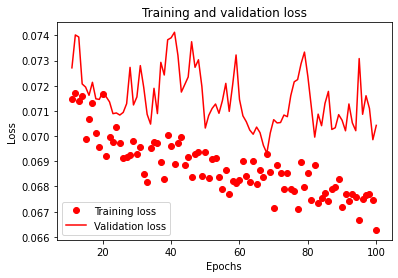

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs[10:],loss[10:],'ro',label='Training loss')
plt.plot(epochs[10:],val_loss[10:],'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

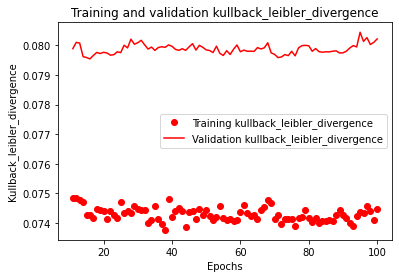

In [ ]:
plt.clf()
kullback_leibler_divergence = history.history['kullback_leibler_divergence']
val_kullback_leibler_divergence = history.history['val_kullback_leibler_divergence']
epochs = range(1,len(kullback_leibler_divergence)+1)

plt.plot(epochs[10:],kullback_leibler_divergence[10:],'ro',label='Training kullback_leibler_divergence')
plt.plot(epochs[10:],val_kullback_leibler_divergence[10:],'r',label='Validation kullback_leibler_divergence')
plt.title('Training and validation kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('Kullback_leibler_divergence')
plt.legend()

plt.show()

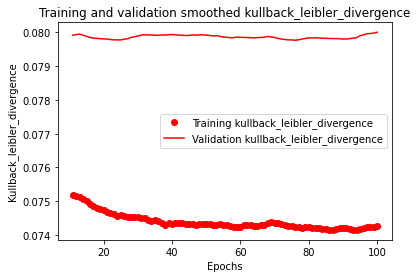

In [ ]:
def smooth_curve(points,factor=0.9):
  smoothed_points=[]
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.clf()
kullback_leibler_divergence = history.history['kullback_leibler_divergence']
val_kullback_leibler_divergence = history.history['val_kullback_leibler_divergence']

smooth_kl_history = smooth_curve(kullback_leibler_divergence)
smooth_val_kl_history = smooth_curve(val_kullback_leibler_divergence)
epochs = range(1,len(kullback_leibler_divergence)+1)

plt.plot(epochs[10:],smooth_kl_history[10:],'ro',label='Training kullback_leibler_divergence')
plt.plot(epochs[10:],smooth_val_kl_history[10:],'r',label='Validation kullback_leibler_divergence')
plt.title('Training and validation smoothed kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('Kullback_leibler_divergence')
plt.legend()

plt.show()

ValueError: ignored

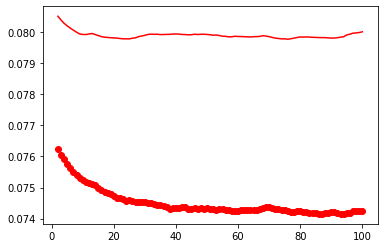

In [ ]:
def smooth_curve(points,factor=0.9):
  smoothed_points=[]
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.clf()
kullback_leibler_divergence = history.history['kullback_leibler_divergence']
val_kullback_leibler_divergence = history.history['val_kullback_leibler_divergence']
kullback_leibler_divergence_baseline = history_baseline.history['kullback_leibler_divergence']
val_kullback_leibler_divergence_baseline = history_baseline.history['val_kullback_leibler_divergence']

smooth_kl_history = smooth_curve(kullback_leibler_divergence)
smooth_val_kl_history = smooth_curve(val_kullback_leibler_divergence)
smooth_kl_history_baseline = smooth_curve(kullback_leibler_divergence_baseline)
smooth_val_kl_history_baseline = smooth_curve(val_kullback_leibler_divergence_baseline)
epochs = range(1,len(kullback_leibler_divergence)+1)

plt.plot(epochs[1:],smooth_kl_history[1:],'ro',label='Training kullback_leibler_divergence')
plt.plot(epochs[1:],smooth_val_kl_history[1:],'r',label='Validation kullback_leibler_divergence')
plt.plot(epochs[1:],smooth_kl_history_baseline[1:],'bo',label='Training kullback_leibler_divergence baseline')
plt.plot(epochs[1:],smooth_val_kl_history_baseline[1:],'b',label='Validation kullback_leibler_divergence baseline')
plt.title('Training and validation smoothed kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('Kullback_leibler_divergence')
plt.legend()

plt.show()

### Final fit

In [ ]:
model_baseline_final = get_model_baseline()
model_baseline_final.compile(optimizer=keras.optimizers.RMSprop(),loss= 'kullback_leibler_divergence', metrics=['acc','kullback_leibler_divergence'])
history_baseline_final = model_baseline_final.fit(X_train,y_train,batch_size=256,epochs=200,validation_data=(X_test,y_test),verbose=1)

Epoch 1/200
8/8 [==============================] - 1s 24ms/step - loss: 0.0837 - acc: 0.1970 - kullback_leibler_divergence: 0.0837 - val_loss: 0.0830 - val_acc: 0.2320 - val_kullback_leibler_divergence: 0.0830
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0811 - acc: 0.2389 - kullback_leibler_divergence: 0.0811 - val_loss: 0.0830 - val_acc: 0.2320 - val_kullback_leibler_divergence: 0.0830
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0822 - acc: 0.2527 - kullback_leibler_divergence: 0.0822 - val_loss: 0.0829 - val_acc: 0.2840 - val_kullback_leibler_divergence: 0.0829
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0820 - acc: 0.2851 - kullback_leibler_divergence: 0.0820 - val_loss: 0.0829 - val_acc: 0.2880 - val_kullback_leibler_divergence: 0.0829
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0815 - acc: 0.2662 - kullback_leibler_divergence: 0.0815 - val_loss: 0.0828 - val_acc: 0.2

In [ ]:
y_pred_baseline = model_baseline_final.predict(X_test)
eval_baseline_sll = clf_eval(y_sl_test,get_single_label(y_pred_baseline),y_pred_baseline)
eval_baseline_mll = clf_eval(y_ml_test,get_multi_label(y_pred_baseline),y_pred_baseline)
eval_baseline = ldl_eval(y_test,y_pred_baseline)

acc: 0.388
f1 score(micro): 0.39960629921259844
precision score(micro): 0.406
recall score(micro): 0.39341085271317827
AUC score(micro): 0.636922817660937
hamming loss: 0.20333333333333334
label ranking loss: 0.2928
confusion matrix: [[[283 101]
  [ 51  65]]

 [[418   0]
  [ 82   0]]

 [[207 142]
  [ 59  92]]

 [[447   0]
  [ 53   0]]

 [[475   0]
  [ 25   0]]

 [[357  54]
  [ 43  46]]]
acc: 0.07
f1 score(micro): 0.4349775784753363
precision score(micro): 0.39551478083588176
recall score(micro): 0.48318804483188044
AUC score(micro): 0.6066372631988259
hamming loss: 0.336
label ranking loss: 0.30896111111111113
confusion matrix: [[[ 87 277]
  [ 10 126]]

 [[324  14]
  [147  15]]

 [[ 72 218]
  [ 25 185]]

 [[369   1]
  [129   1]]

 [[435   8]
  [ 55   2]]

 [[317  75]
  [ 49  59]]]
Kullback–Leibler divergence:  0.07031856124670693
Euclidean distance:  0.15271856057490102
MSE:  0.004760165856459085
Chebyshev distance:  0.12354125316248106
Clark distance:  0.3811317111167079
Canberra dist

In [ ]:
model_final = model_baseline_final
model_final.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),loss= label_ambiguity_loss, metrics=['acc','kullback_leibler_divergence'])
history_final = model_final.fit(X_train,y_train,batch_size=256,epochs=50,validation_data=(X_test,y_test),verbose=1)

Epoch 1/50
8/8 [==============================] - 1s 32ms/step - loss: 0.0806 - acc: 0.3863 - kullback_leibler_divergence: 0.0732 - val_loss: 0.0765 - val_acc: 0.3940 - val_kullback_leibler_divergence: 0.0709
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0752 - acc: 0.3961 - kullback_leibler_divergence: 0.0714 - val_loss: 0.0750 - val_acc: 0.3920 - val_kullback_leibler_divergence: 0.0708
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0768 - acc: 0.3803 - kullback_leibler_divergence: 0.0724 - val_loss: 0.0752 - val_acc: 0.3980 - val_kullback_leibler_divergence: 0.0710
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0720 - acc: 0.3809 - kullback_leibler_divergence: 0.0710 - val_loss: 0.0751 - val_acc: 0.3860 - val_kullback_leibler_divergence: 0.0712
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0745 - acc: 0.3837 - kullback_leibler_divergence: 0.0731 - val_loss: 0.0753 - val_acc: 0.3820 -

In [ ]:
y_pred = model_final.predict(X_test)
eval_sll = clf_eval(y_sl_test,get_single_label(y_pred),y_pred)
eval_mll = clf_eval(y_ml_test,get_multi_label(y_pred),y_pred)
eval = ldl_eval(y_test,y_pred)

acc: 0.378
f1 score(micro): 0.3937007874015748
precision score(micro): 0.4
recall score(micro): 0.3875968992248062
AUC score(micro): 0.6334119761824515
hamming loss: 0.20533333333333334
label ranking loss: 0.32820000000000005
confusion matrix: [[[366  18]
  [ 90  26]]

 [[418   0]
  [ 82   0]]

 [[142 207]
  [ 31 120]]

 [[447   0]
  [ 53   0]]

 [[475   0]
  [ 25   0]]

 [[336  75]
  [ 35  54]]]
acc: 0.11
f1 score(micro): 0.44332210998877664
precision score(micro): 0.4034729315628192
recall score(micro): 0.4919053549190536
AUC score(micro): 0.6130441658527903
hamming loss: 0.33066666666666666
label ranking loss: 0.3286055555555556
confusion matrix: [[[294  70]
  [ 75  61]]

 [[316  22]
  [139  23]]

 [[ 79 211]
  [ 29 181]]

 [[247 123]
  [ 65  65]]

 [[377  66]
  [ 53   4]]

 [[300  92]
  [ 47  61]]]
Kullback–Leibler divergence:  0.07312496478522547
Euclidean distance:  0.15293117601968456
MSE:  0.004929100720677145
Chebyshev distance:  0.12519112990550932
Clark distance:  0.37885638

ValueError: ignored

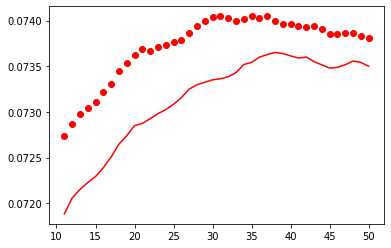

In [ ]:
def smooth_curve(points,factor=0.9):
  smoothed_points=[]
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.clf()
kullback_leibler_divergence = history_final.history['kullback_leibler_divergence']
val_kullback_leibler_divergence = history_final.history['val_kullback_leibler_divergence']
kullback_leibler_divergence_baseline = history_baseline_final.history['kullback_leibler_divergence']
val_kullback_leibler_divergence_baseline = history_baseline_final.history['val_kullback_leibler_divergence']

smooth_kl_history = smooth_curve(kullback_leibler_divergence)
smooth_val_kl_history = smooth_curve(val_kullback_leibler_divergence)
smooth_kl_history_baseline = smooth_curve(kullback_leibler_divergence_baseline)
smooth_val_kl_history_baseline = smooth_curve(val_kullback_leibler_divergence_baseline)
epochs = range(1,len(kullback_leibler_divergence)+1)

plt.plot(epochs[10:],smooth_kl_history[10:],'ro',label='Training kullback_leibler_divergence')
plt.plot(epochs[10:],smooth_val_kl_history[10:],'r',label='Validation kullback_leibler_divergence')
plt.plot(epochs[10:],smooth_kl_history_baseline[10:],'bo',label='Training kullback_leibler_divergence baseline')
plt.plot(epochs[10:],smooth_val_kl_history_baseline[10:],'b',label='Validation kullback_leibler_divergence baseline')
plt.title('Training and validation smoothed kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('Kullback_leibler_divergence')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points,factor=0.9):
  smoothed_points=[]
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.clf()
la_loss = history_final.history['laloss']
val_la_loss = history_final.history['val_laloss']
la_loss_baseline = history_baseline_final.history['laloss']
val_la_loss_baseline = history_baseline_final.history['val_laloss']

smooth_laloss_history = smooth_curve(la_loss)
smooth_val_laloss_history = smooth_curve(val_la_loss)
smooth_laloss_history_baseline = smooth_curve(la_loss_baseline)
smooth_val_laloss_history_baseline = smooth_curve(val_la_loss_baseline)
epochs = range(1,len(la_loss)+1)

plt.plot(epochs[10:],smooth_laloss_history[10:],'ro',label='Training laloss')
plt.plot(epochs[10:],smooth_val_laloss_history[10:],'r',label='Validation laloss')
plt.plot(epochs[10:],smooth_laloss_history_baseline[10:],'bo',label='Training laloss baseline')
plt.plot(epochs[10:],smooth_val_laloss_history_baseline[10:],'b',label='Validation laloss baseline')
plt.title('Training and validation smoothed laloss')
plt.xlabel('Epochs')
plt.ylabel('laloss')
plt.legend()

plt.show()

KeyError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
def smooth_curve(points,factor=0.9):
  smoothed_points=[]
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.clf()
la_loss = history_final.history['new_laloss']
val_la_loss = history_final.history['val_new_laloss']
la_loss_baseline = history_baseline_final.history['new_laloss']
val_la_loss_baseline = history_baseline_final.history['val_new_laloss']

smooth_laloss_history = smooth_curve(la_loss)
smooth_val_laloss_history = smooth_curve(val_la_loss)
smooth_laloss_history_baseline = smooth_curve(la_loss_baseline)
smooth_val_laloss_history_baseline = smooth_curve(val_la_loss_baseline)
epochs = range(1,len(la_loss)+1)

plt.plot(epochs[10:],smooth_laloss_history[10:],'ro',label='Training laloss')
plt.plot(epochs[10:],smooth_val_laloss_history[10:],'r',label='Validation laloss')
plt.plot(epochs[10:],smooth_laloss_history_baseline[10:],'bo',label='Training laloss baseline')
plt.plot(epochs[10:],smooth_val_laloss_history_baseline[10:],'b',label='Validation laloss baseline')
plt.title('Training and validation smoothed new laloss')
plt.xlabel('Epochs')
plt.ylabel('new laloss')
plt.legend()

plt.show()

KeyError: ignored

<Figure size 432x288 with 0 Axes>

## VGG16

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
          include_top=False,
          input_shape=(150,150,3))

## Multilayer perceptron

Define network structure

Simple multi-layer perceptron, input -> two hidden layers -> output.

In [ ]:
def perceptron(feature_dim,label_dim):
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dropout(0.2, input_shape=(feature_dim,)))
    model.add(Dense(500, activation='relu' ,kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='relu' ,kernel_regularizer=regularizers.l2(0.003)))
    model.add(Dense(label_dim, activation='sigmoid',kernel_regularizer=regularizers.l2(0.0001)))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc', precision, recall, f1measure]) 
    return model


def train_perceptron(X_train,y_train,X_test,y_test):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = perceptron(feature_dim,label_dim)
    model.summary()
    fit_history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_test,y_test), verbose=0)
    return model,fit_history

Define metrics

In [ ]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')     
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def f1measure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

 Load a multi-label dataset, if not done before.

In [ ]:
data = spio.loadmat(data_path['slashdot'])
X = data['features']
y = data['labels']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2647, 1079) (1135, 1079) (2647, 22) (1135, 22)


Fit the model.

In [ ]:
[clf_nn, clf_nn_history] = train_perceptron(X_train,y_train,X_test,y_test)

create model. feature_dim =1079, label_dim =22
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_16 (Dropout)         (None, 1079)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)               540000    
_________________________________________________________________
dropout_17 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_18 (Dense)             (None, 22)                4422      
Total params: 644,622
Trainable params: 644,622
Non-trainable params: 0
_________________________________________________________________


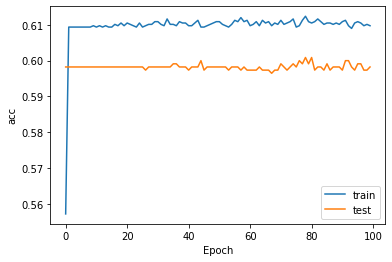

In [ ]:
# plot history
plt.plot(clf_nn_history.history['acc'], label='train')
plt.plot(clf_nn_history.history['val_acc'], label='test')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Evaluate the model on test set.

In [ ]:
y_pred = (clf_nn.predict(X_test)>0.5).astype("int32")
y_scores = clf_nn.predict(X_test)
print('nn Eval')
eval_nn = clf_eval(y_test,y_pred,y_scores)

nn Eval
acc: 0.6960352422907489
f1 score(micro): 0.7779005524861878
precision score(micro): 0.88
recall score(micro): 0.697029702970297
AUC score(micro): 0.8465115125869849
hamming loss: 0.016099319183019625
label ranking loss: 0.032936857562408224


On training set.

In [ ]:
y_pred = (clf_nn.predict(X_train)>0.5).astype("int32")
y_scores = clf_nn.predict(X_train)
print('nn Eval')
eval_nn = clf_eval(y_train,y_pred,y_scores)

nn Eval
acc: 0.7514166981488477
f1 score(micro): 0.8188268684957427
precision score(micro): 0.9448689956331878
recall score(micro): 0.7224540901502504
AUC score(micro): 0.8603226430549955
hamming loss: 0.013153827660816705
label ranking loss: 0.035681178137384764


Comparison with random forest classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RandomForest = RandomForestClassifier(n_estimators=100)
clf_RandomForest.fit(X_train, y_train)
y_pred, y_scores = clf_pre(clf_RandomForest,X_test)
print('RandomForest Eval')
eval_RF = clf_eval(y_test,y_pred,y_scores)

NameError: ignored

Random Forest on training set

In [ ]:
y_pred, y_scores = clf_pre(clf_RandomForest,X_train)
print('RandomForest Eval')
eval_RF = clf_eval(y_train,y_pred,y_scores)

For LDL Task

In [ ]:
y_pred = clf_nn.predict(X_test)
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i]/sum(y_pred[i])
loss_test_mean = np.mean(scipy.stats.entropy(y_test,y_pred))
print("Testing set")
print("kl_dist mean:",loss_test_mean)

## AutoEncoder

Fully connected network autoencoder

creat & complie

In [ ]:
# use a fully connected network
feature_dim = X_train.shape[1]
net_input = Input(shape=(feature_dim,))
## encoder
encoder = Dropout(0.2)(net_input)
encoder = Dense(500,activation="relu")(encoder)
encoder = Dropout(0.5)(encoder)
encoder = Dense(32,activation="relu")(encoder)
## decoder
decoder = Dense(500,activation="relu")(encoder)
decoder = Dropout(0.5)(decoder)
decoder = Dense(feature_dim,activation="relu")(decoder)
## combined to autoencoder

autoencoder = Model(inputs=net_input, outputs=decoder)
autoencoder.summary()
## compile
autoencoder.compile(optimizer="adam",loss="binary_crossentropy")


Unfinished stack AE

In [ ]:
# use a fully connected network
input_dim = X_train.shape[1]
input_features = Input(shape=(input_dim,))
## encoder
encoder1 = Dense(128,activation="relu",name="enco1")(input_features)
decoder1 = Dense(input_dim,activation="relu",name="deco1")(encoder1)
autoencoder1 = Model(input=input_features, output=decoder1)
autoencoder1.compile(optimizer="adam",loss="binary_crossentropy")

input2 = Input(shape=(128,))
encoder2 = Dense(64,activation="relu",name="enco2")(input2)
decoder2 = Dense(128,activation="relu",name="deco2")(encoder2)
autoencoder2 = Model(input=input2, output=decoder2)
autoencoder2.compile(optimizer="adam",loss="binary_crossentropy")

input3 = Input(shape=(64,))
encoder3 = Dense(32,activation="relu",name="enco3")(input3)
decoder3 = Dense(64,activation="relu",name="deco3")(encoder3)
autoencoder3 = Model(input=input3, output=decoder3)
autoencoder3.compile(optimizer="adam",loss="binary_crossentropy")

input4 = Input(shape=(32,))
encoder4 = Dense(16,activation="relu",name="enco4")(input4)
decoder4 = Dense(32,activation="relu",name="deco4")(encoder4)
autoencoder4 = Model(input=input4, output=encoder4)
autoencoder4.compile(optimizer="adam",loss="binary_crossentropy")

autoencoder1_fit = autoencoder1.fit(X_train,X_train,batch_size=256,epochs=200,
                        validation_data=(X_test,X_test),verbose=0)

autoencoder2_fit = autoencoder2.fit(X_train,X_train,batch_size=256,epochs=200,
                        validation_data=(X_test,X_test),verbose=0)

Fit the model

In [ ]:
autoencoder_fit = autoencoder.fit(X_train,X_train,batch_size=256,epochs=100,
                        validation_data=(X_test,X_test),verbose=0)

Evaluate the model

In [ ]:
# plot history
plt.figure(figsize=(9,6))
plt.plot(autoencoder_fit.history['loss'], label='train')
plt.plot(autoencoder_fit.history['val_loss'], label='test')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

Get the encoder

In [ ]:
Encoder = Model(net_input, encoder)
X_train_encoded = Encoder.predict(X_train)
X_test_encoded = Encoder.predict(X_test)
encoded_feature_train = pd.DataFrame(X_train_encoded)
encoded_feature_train.describe()

In [ ]:
encoded_feature_test = pd.DataFrame(X_test_encoded)
encoded_feature_test.describe()

### Classification task

Use encoded features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RandomForest = RandomForestClassifier(n_estimators=100)
clf_RandomForest.fit(X_train_encoded, y_train)
y_pred, y_scores = clf_pre(clf_RandomForest,X_test_encoded)
print('RandomForest Eval')
eval_RF = clf_eval(y_test,y_pred,y_scores)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf_KNN = KNeighborsClassifier()
clf_KNN.fit(X_train_encoded, y_train)
y_pred, y_scores = clf_pre(clf_KNN,X_test_encoded)
print('KNN Eval')
eval_RF = clf_eval(y_test,y_pred,y_scores)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
def linear_model(feature_dim,label_dim):
    model = Sequential()
    model.add(Dense(label_dim,input_dim=feature_dim,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return model
    
def train_linear(X_train,y_train,X_test,y_test):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = linear_model(feature_dim,label_dim)
    model.fit(X_train,y_train,batch_size=128, epochs=100, validation_data=(X_test,y_test),verbose=0)
    return model


In [ ]:
clf_linear = train_linear(X_train_encoded,y_train,X_test_encoded,y_test)
y_pred = (clf_linear.predict(X_test_encoded)>0.5).astype("int32")
y_scores = clf_linear.predict(X_test_encoded)
print('linear Eval')
eval_linear = clf_eval(y_test,y_pred,y_scores)

Use raw features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RandomForest = RandomForestClassifier(n_estimators=100)
clf_RandomForest.fit(X_train, y_train)
y_pred, y_scores = clf_pre(clf_RandomForest,X_test)
print('RandomForest Eval')
eval_RF = clf_eval(y_test,y_pred,y_scores)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf_KNN = KNeighborsClassifier()
clf_KNN.fit(X_train, y_train)
y_pred, y_scores = clf_pre(clf_KNN,X_test)
print('KNN Eval')
eval_RF = clf_eval(y_test,y_pred,y_scores)

In [ ]:
clf_linear = train_linear(X_train,y_train,X_test,y_test)
y_pred = (clf_linear.predict(X_test)>0.5).astype("int32")
y_scores = clf_linear.predict(X_test)
print('linear Eval')
eval_linear = clf_eval(y_test,y_pred,y_scores)

### Regression Task

Use encoded features

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train_encoded, y_train)

In [ ]:
y_pred_train = regressor.predict(X_train_encoded)
for i in range(len(y_pred_train)):
  y_pred_train[i] = y_pred_train[i]/sum(y_pred_train[i])
loss_train_mean = np.mean(scipy.stats.entropy(y_train,y_pred_train))
print("train set")
print("kl_dist mean:",loss_train_mean)

In [ ]:
y_pred = regressor.predict(X_test_encoded)
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i]/sum(y_pred[i])
loss_test_mean = np.mean(scipy.stats.entropy(y_test,y_pred))
print("test set")
print("kl_dist mean:",loss_test_mean)

Use raw features

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train, y_train)

In [ ]:
y_pred_train = regressor.predict(X_train)
for i in range(len(y_pred_train)):
  y_pred_train[i] = y_pred_train[i]/sum(y_pred_train[i])
loss_train_mean = np.mean(scipy.stats.entropy(y_train,y_pred_train))
print("train set")
print("kl_dist mean:",loss_train_mean)

In [ ]:
y_pred = regressor.predict(X_test)
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i]/sum(y_pred[i])
loss_test_mean = np.mean(scipy.stats.entropy(y_test,y_pred))
print("test set")
print("kl_dist mean:",loss_test_mean)

# Auto-Sklearn

## Classification model

Install required libraries.

In [ ]:
#compiler
!apt-get install swig

#dependencies
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip3 install

#auto-sklearn
!pip3 install auto-sklearn

In [ ]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets

Load a multi-label dataset, if not done before.

In [ ]:
data = spio.loadmat(data_path['yeast'])
X = data['features']
y = data['labels']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1691, 103) (726, 103) (1691, 14) (726, 14)


Set the upper limit of automl running time. The example is for demonstration only, so set for a short time.

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=500,per_run_time_limit=50)
automl.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


AutoSklearnClassifier(delete_output_folder_after_terminate=True,
                      delete_tmp_folder_after_terminate=True,
                      disable_evaluator_output=False,
                      ensemble_memory_limit=1024, ensemble_nbest=50,
                      ensemble_size=50, exclude_estimators=None,
                      exclude_preprocessors=None, get_smac_object_callback=None,
                      include_estimators=None, include_preprocessors=None,
                      initial_configurations_via_metalearning=25,
                      logging_config=None, max_models_on_disc=50,
                      metadata_directory=None, ml_memory_limit=3072,
                      n_jobs=None, output_folder=None, per_run_time_limit=50,
                      resampling_strategy='holdout',
                      resampling_strategy_arguments=None, seed=1,
                      shared_mode=False, smac_scenario_args=None,
                      time_left_for_this_task=500, tmp_folder=Non

The return value format of predict_proba in auto-sklearn is not the same as the sklearn classifier. It is a score, and no need to further process.

In [ ]:
y_pred = automl.predict(X_test)
y_scores = automl.predict_proba(X_test)
print('automl')
eval_automl = clf_eval(y_test,y_pred,y_scores)

automl
f1 score(micro): 0.0
precision score(micro): 0.0
recall score(micro): 0.0
hamming loss: 0.061615384615384614
label ranking loss: 0.9589745324520381


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Comparison with random forest classifier.

In [ ]:
clf_RandomForest.fit(X_train, y_train)
y_pred, y_scores = clf_pre(clf_RandomForest,X_test)
print('RandomForest Eval')
eval_RF = clf_eval(y_test,y_pred,y_scores)

RandomForest Eval
f1 score(micro): 0.28365878725590954
precision score(micro): 0.8023255813953488
recall score(micro): 0.17228464419475656
hamming loss: 0.05361538461538461
label ranking loss: 0.12859110802084928


Note that auto-sklearn can customize proxy indicators:



```
def accuracy(solution, prediction):
    # custom function defining accuracy
    return np.mean(solution == prediction)

accuracy_scorer = autosklearn.metrics.make_scorer(
    name="accu",
    score_func=accuracy,
    optimum=1,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
)
```



# Auto-Keras

In [ ]:
!pip3 install autokeras

In [ ]:
from autokeras import StructuredDataClassifier
from keras.utils.np_utils import to_categorical

data = spio.loadmat(data_path['image'])
X = data['features']
y = data['labels']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)




(1400, 294) (600, 294) (1400, 5) (600, 5)


In [ ]:
y_train = to_categorical(y_train,y_train.shape[1])
y_test = to_categorical(y_test,y_test.shape[1])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = StructuredDataClassifier(num_classes=5,multi_label=True)
clf.fit(X_train, y_train, epochs=5)

In [ ]:
clf.final_fit(X_train, y_train, X_test, y_test, retrain=true)
y = clf.evaluate(X_test, y_test, batch_size=128)

print(y)

# More LDL algorithm

## BC-LDL

Wang K, Geng X. Binary Coding based Label Distribution Learning[C]//IJCAI. 2018: 2783-2789.

In [ ]:
!pip install pynndescent

In [ ]:
from pynndescent import NNDescent
from scipy import sparse
train_num = X_train.shape[0]
feature_num = X_train.shape[1]
label_num = y_train.shape[1]
bias = np.ones(train_num)
alpha = 2
X_train_b = np.column_stack((X_train, bias))
y_train_mean = np.repeat(np.mean(y_train, axis=0).reshape(1, label_num), train_num, axis=0)
temp1 = np.repeat(np.sqrt(np.sum((y_train-y_train_mean)**2, axis=1).reshape(-1, 1)), label_num, axis=1)
d = (y_train-y_train_mean)/temp1
g0 = np.dot(np.dot(X_train_b.T, d), np.dot(X_train_b.T, d).T)
g1 = alpha*g0
gt = g1
w_b = np.zeros((feature_num+1, alpha), dtype='float64')


In [ ]:
for t in range(alpha):
    eigenvalue, eigenvector = np.linalg.eig(gt)
    eigenvalue = np.real(eigenvalue)
    eigenvector = np.real(eigenvector)
    eigenvalue_index = np.argmax(eigenvalue)
    w_b[:, t] = eigenvector[:, eigenvalue_index]
    temp2 = np.dot(X_train_b.T, np.sign(np.dot(X_train_b, w_b[:, t].reshape(-1, 1))))
    gt = gt - np.dot(temp2, temp2.T)
w = w_b[0:feature_num, :]
e = w_b[feature_num, :]
binary_code_pre = np.sign(np.dot(X_test, w)+e)
binary_code_matrix = np.sign(np.dot(X_train_b, w_b))

ann = NNDescent(binary_code_matrix,compressed=True,n_jobs=-1)
neighbors_index, neighbors_B = ann.query(binary_code_pre, k=5)

Evaluate the kl loss on the testing set

In [ ]:
y_pred = np.zeros((len(X_test), label_num))
for i in range(len(X_test)):
    y_pred[i] = np.average(y_train[neighbors_index[i]], axis=0)
loss_test_mean = np.mean(scipy.stats.entropy(y_test,y_pred))
print("Testing set")
print("kl_dist mean:",loss_test_mean)

Testing set
kl_dist mean: 0.1728530329588176


## MSLP-LDL

Peng C L, Tao A, Geng X. Label Embedding Based on Multi-Scale Locality Preservation[C]//IJCAI. 2018: 2623-2629.

In [ ]:
def predict_func(v, x_train, y_train, x_test, k):
    test_num = len(x_test)
    label_num = len(y_train[0])
    y_train_l = np.dot(x_train, v)
    y_test_l = np.dot(x_test, v)
    neigh = neighbors.NearestNeighbors(n_neighbors=k)
    neigh.fit(y_train_l)
    neiy_index = neigh.kneighbors(y_test_l, return_distance=False)
    y_pre = np.zeros((test_num, label_num))
    for i in range(test_num):
        y_pre[i] = np.average(y_train[neiy_index[i]], axis=0)
    return y_pre

    
def euclidean(A, B):
    if np.shape(A)[1] != np.shape(B)[1]:
        raise ValueError('A and B must be of same dimensionality.')

    if np.shape(A)[1] == 1:
        A = A.reshape(-1, 1)
        B = B.reshape(-1, 1)
    an = np.shape(A)[0]
    bn = np.shape(B)[0]

    a = np.sum(A * A, 1)
    b = np.sum(B * B, 1)
    ab = A.dot(B.T)

    D = np.sqrt(np.abs(np.repeat(a.reshape(-1, 1), bn, 1) + np.repeat(np.array([b]), an, 0) - 2 * ab))
    return D

In [ ]:
from sklearn import neighbors
alpha = 10
k = 1
l = 1
k1 = 2
k2 = 2
beta = 0.1
lambda1 = 0.01

train_num = X_train.shape[0]
feature_num = X_train.shape[1]
label_num = y_train.shape[1]
w1 = np.zeros((train_num, train_num))
w2 = np.zeros((train_num, train_num))
neighx = neighbors.NearestNeighbors(n_neighbors=alpha * k1 + 1)
neighx.fit(X_train)
nx_index = neighx.kneighbors(X_train, return_distance=False)[:, 1:alpha * k1 + 1]
ny_d = np.zeros((train_num, k1))
ny_index = np.zeros((train_num, k1), dtype=int)
neighy = neighbors.NearestNeighbors(n_neighbors=k1)
for i in range(train_num):
    neighy.fit(y_train[nx_index[i]])
    ny_d[i], ny_index[i] = neighy.kneighbors(y_train[i].reshape(1, -1))

neighx_k2 = neighbors.NearestNeighbors(n_neighbors=k2 + 1)
neighx_k2.fit(X_train)
nx_k2_index = neighx_k2.kneighbors(X_train, return_distance=False)[:, 1:k2 + 1]
distence_y = euclidean(y_train, y_train)
ny_far_index = np.argsort(-distence_y, axis=1)
ny_far_index = np.argwhere(ny_far_index < k2)
sigma = np.sum(ny_d ** 2) / (train_num * k1)
for i in range(train_num):
    for j in range(k1):
        w1[i][ny_index[i, j]] = np.exp(-ny_d[i, j] / sigma)
        w1[ny_index[i, j]][i] = w1[i][ny_index[i, j]]
        w2[i][ny_far_index[i * k2 + j, 1]] = 1
        w2[ny_far_index[i * k2 + j, 1]][i] = 1

D1 = np.zeros((train_num, train_num))
D2 = np.zeros((train_num, train_num))
for i in range(train_num):
    D1[i, i] = np.sum(w1[i])
    D2[i, i] = np.sum(w2[i])
M1 = D1 - w1
M2 = D2 - w2

M = beta * M1 - (1 - beta) * M2
term1 = np.linalg.pinv(np.dot(np.dot(X_train.T, D1), X_train))
term2 = np.dot(np.dot(X_train.T, M), X_train) + lambda1 * np.identity(len(x_train[0]))
eigenvalue, eigenvector = np.linalg.eig(term1 * term2)
eigenvalue_sort_index = np.argsort(eigenvalue)
eigenvalue_index = np.argwhere(eigenvalue_sort_index < l)
v = np.zeros((len(X_train[0]), l))
for i in range(l):
    v[:, i:i + 1] = eigenvector[:, eigenvalue_index[i]]

In [ ]:
from sklearn import neighbors
train_num = X_train.shape[0]
feature_num = X_train.shape[1]
label_num = y_train.shape[1]
w1 = np.zeros((train_num,train_num))
w2 = np.zeros((train_num, train_num))
neighbor_x = neighbors.NearestNeighbors(n_neighbors=20)
neighbor_x.fit(X_train)
neighbor_x_index = neighx.kneighbors(X_train, return_distance=False)[:, 1:20]

In [ ]:
y_pred = predict_func(v, x_train, y_train, x_test, k)
loss_test_mean = np.mean(scipy.stats.entropy(y_test,y_pred))
print("Testing set")
print("kl_dist mean:",loss_test_mean)